In [2]:
import pandas as pd
from pedigree_tools import PedSims, PedigreeNetwork, Karyogram, ProcessSegments
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [49]:
temp_segs = pd.concat([pd.read_feather(f"/Users/cole/Desktop/brown/ponderosa/phasedibd_segments/Himba_shapeit.chr{chrom}_segments.f") for chrom in range(1, 23)])

In [50]:
temp_segs["PAIR_ID"] = temp_segs.apply(lambda x: "_".join(sorted([x.id1, x.id2])), axis = 1)
pairs_df = pd.read_csv("/Users/cole/Desktop/brown/ponderosa/Himba_pairs.txt", delim_whitespace = True)
pairs_df

,PAIR_ID,IID1,IID2,GTD,IBD1,IBD2,PIHAT,KINGINF,REL,DEGREE
0,HMB004_HMB856,HMB004,HMB856,True,0.5086,0.0032,0.2575,2nd,MHS,2nd
1,HMB004_HMB2970,HMB004,HMB2970,True,0.5057,0.0180,0.2709,2nd,MHS,2nd
2,HMB005_HMB699,HMB005,HMB699,True,0.4282,0.3466,0.5607,FS,FS,FS
3,HMB005_HMB013,HMB005,HMB013,True,0.5922,0.0177,0.3138,2nd,PHS,2nd
4,HMB005_HMB1037,HMB005,HMB1037,True,0.5585,0.0072,0.2864,2nd,PHS,2nd
...,...,...,...,...,...,...,...,...,...,...
5234,HMB169_HMB999,HMB999,HMB169,True,0.9667,0.0320,0.5153,PO,PO,PO
5235,HMB359_HMB999,HMB999,HMB359,True,0.9734,0.0252,0.5119,PO,PO,PO
5236,HMB3119_HMB999,HMB999,HMB3119,True,0.5983,0.0065,0.3057,2nd,GP,2nd
5237,HMB060_HMB999,HMB999,HMB060,True,0.6338,0.0090,0.3259,2nd,GP,2nd


In [51]:
himba_segs = temp_segs[temp_segs.PAIR_ID.isin(pairs_df[pairs_df.DEGREE == "2nd"]["PAIR_ID"])].reset_index(drop = True)



In [52]:
pair_data = {}
p = PedSims("/Users/cole/Desktop/brown/ponderosa/Untitled/")


for (id1, id2, pair_id), pair_df in himba_segs.groupby(["id1", "id2", "PAIR_ID"]):
    pair_df["l"] = pair_df["end_cm"] - pair_df["start_cm"]
    pair_data[pair_id] = p.pair_segments(id1, id2, pair_df, 10)
#     print(pairs_df[pairs_df.PAIR_ID == "_".join(sorted([id1, id2]))]["REL"].squeeze())

In [53]:
n = PedigreeNetwork("/Users/cole/Desktop/brown/ponderosa/Himba_no2278.fam")
for index, row in pairs_df.iterrows():
    if row["REL"] == "GP":
        id1, id2 = row["IID1"], row["IID2"]
        r = n.find_relationship(id1, id2)[3]
        if len(r) == 0:
            continue
        r = [i for i in r if "GP" in i][0]
        r = "MGP" if r[2] == "2" else "PGP"
        pairs_df.at[index, "REL"] = r
        

In [54]:
second_pairs = pairs_df[pairs_df.GTD & (pairs_df.DEGREE == "2nd")].copy()
second_pairs["n"] = pairs_df.apply(lambda x: np.nan if x.PAIR_ID not in pair_data else pair_data[x.PAIR_ID].n_segs, axis = 1)
for group, group_df in second_pairs.groupby("REL"):
    print(group, group_df["n"].mean(), group_df["n"].std(), group_df.shape)



AV 52.709030100334445 4.503423611423107 (299, 11)
GP 40.214285714285715 5.025757829247421 (14, 11)
MGP 42.27436823104693 4.449860775562042 (277, 11)
MHS 52.68867924528302 4.395598932711155 (424, 11)
PGP 36.03968253968254 4.757143333809977 (126, 11)
PHS 44.447688564476884 4.3205762104812155 (411, 11)


In [55]:
fam = pd.read_csv("/Users/cole/Desktop/brown/ponderosa/Himba_no2278.fam", delim_whitespace = True, header = None, dtype = str)
fam.columns = ["FID", "IID", "Father", "Mother", "Sex", "Pheno"]
pedigree = nx.DiGraph()
pedigree.add_nodes_from([[row["IID"], dict(sex=row["Sex"])] for _, row in fam.iterrows()])
pedigree.add_edges_from([list(i) + [dict(dir="down")] for i in fam[fam.Father != "0"][["Father", "IID"]].values])
pedigree.add_edges_from([list(i) + [dict(dir="down")] for i in fam[fam.Mother != "0"][["Mother", "IID"]].values])
pedigree.add_edges_from([list(i) + [dict(dir="up")] for i in fam[fam.Father != "0"][["IID", "Father"]].values])
pedigree.add_edges_from([list(i) + [dict(dir="up")] for i in fam[fam.Mother != "0"][["IID", "Mother"]].values])


def annotate_path(path):
    down = False
    anno_path = []
    for index in range(len(path)-1):
        d = pedigree.get_edge_data(path[index], path[index+1])["dir"]
        down = down or d == "down"
        if down and d == "up":
            return []
        anno_path.append(d)
    return anno_path
    

In [56]:
paths = dict(nx.all_pairs_shortest_path(pedigree, 5))

In [57]:
rels = []
for id1 in paths:
    for id2 in paths[id1]:
        if id1 >= id2:
            continue
        path_list = [annotate_path(i) for i in nx.all_simple_paths(pedigree, source = id1, target = id2, cutoff = 5)]
        path_list = [tuple(i) for i in path_list if len(i) > 0 and i[0] == "up"]
        if len(path_list) == 0:
            continue
        rels.append([id1, id2, path_list])


In [58]:
rels = {"G"*i + "P": ["up" for _ in range(i+1)] for i in range(1, 5)}
rels["AV"] = ["up", "up", "down"]
rels["CO"] = ["up", "up", "down", "down"]
rels["sib"] = ["up", "down"]
rels["PO"] = ["up"]
rels = {tuple(j): i for i, j in rels.items()}


rel_dict = rels
rel_dict

{('up', 'up'): 'GP',
 ('up', 'up', 'up'): 'GGP',
 ('up', 'up', 'up', 'up'): 'GGGP',
 ('up', 'up', 'up', 'up', 'up'): 'GGGGP',
 ('up', 'up', 'down'): 'AV',
 ('up', 'up', 'down', 'down'): 'CO',
 ('up', 'down'): 'sib',
 ('up',): 'PO'}

In [59]:
def legit_path(dir_path):
    down = False
    for d in dir_path:
        down = down or d == "down"
        if down and d == "up":
            return False
    return True

'''Path dir can be up...up, down...down, down...up, or up...down'''
def reverse_path(id1, id2, path, path_dir):
    # id1 is the genetically older individual
    if path_dir.count("down") > path_dir.count("up"):
        path_dir = [{"down": "up", "up": "down"}[i] for i in path_dir[::-1]]
        path = path[::-1]
        id1, id2 = id2, id1
    return id1, id2, path, path_dir
        
    
def find_relationship(id1, id2):
    paths = list(nx.all_simple_paths(pedigree, source = id1, target = id2, cutoff = 5))
    for index, path in enumerate(paths):
        path_dir = [pedigree.get_edge_data(path[index], path[index+1])["dir"] for index in range(len(path)-1)]
        id1_temp, id2_temp, path, path_dir = reverse_path(id1, id2, path, path_dir)
        paths[index] = [id1_temp, id2_temp, pedigree.nodes[path[1]]["sex"], path_dir]
    out_paths = []
    for id1, id2, sex, path_dir in paths:
        if legit_path(path_dir):
            propIBD = 0.5**len(path_dir)
            out_paths.append([id1, id2, sex, rel_dict.get(tuple(path_dir), path_dir), propIBD])
    return out_paths

find_relationship("HMB2983", "HMB007")
# find_relationship("HMB014", "HMB017")

[['HMB2983', 'HMB007', '1', 'GP', 0.25]]

In [60]:
paths = dict(nx.all_pairs_shortest_path(pedigree, 5))

rels = []
for id1 in paths:
    for id2 in paths[id1]:
        if id1 >= id2:
            continue
        relationships = find_relationship(id1, id2)
        rels.append(relationships)

[i for i in rels if len(i) > 1]

[[['HMB005', 'HMB699', '1', 'sib', 0.25],
  ['HMB005', 'HMB699', '2', 'sib', 0.25]],
 [['HMB014', 'HMB022', '1', 'sib', 0.25],
  ['HMB014', 'HMB022', '2', 'sib', 0.25]],
 [['HMB014', 'HMB308', '1', 'sib', 0.25],
  ['HMB014', 'HMB308', '2', 'sib', 0.25]],
 [['HMB014', 'HMB972', '1', 'sib', 0.25],
  ['HMB014', 'HMB972', '2', 'sib', 0.25]],
 [['HMB014', 'HMB975', '1', 'sib', 0.25],
  ['HMB014', 'HMB975', '2', 'sib', 0.25]],
 [['HMB017', 'HMB014', '2', 'AV', 0.125],
  ['HMB017', 'HMB014', '2', 'AV', 0.125]],
 [['HMB098', 'HMB014', '2', 'AV', 0.125],
  ['HMB098', 'HMB014', '2', 'AV', 0.125]],
 [['HMB355', 'HMB014', '2', 'AV', 0.125],
  ['HMB355', 'HMB014', '2', 'AV', 0.125]],
 [['HMB2274', 'HMB014', '2', 'AV', 0.125],
  ['HMB2274', 'HMB014', '2', 'AV', 0.125]],
 [['HMB2901', 'HMB014', '2', ['up', 'up', 'up', 'down'], 0.0625],
  ['HMB2901', 'HMB014', '2', ['up', 'up', 'up', 'down'], 0.0625]],
 [['HMB2902', 'HMB014', '2', ['up', 'up', 'up', 'down'], 0.0625],
  ['HMB2902', 'HMB014', '2', ['up'

In [61]:
for i in rels:
    if len(i) > 1:
        print(i)

[['HMB005', 'HMB699', '1', 'sib', 0.25], ['HMB005', 'HMB699', '2', 'sib', 0.25]]
[['HMB014', 'HMB022', '1', 'sib', 0.25], ['HMB014', 'HMB022', '2', 'sib', 0.25]]
[['HMB014', 'HMB308', '1', 'sib', 0.25], ['HMB014', 'HMB308', '2', 'sib', 0.25]]
[['HMB014', 'HMB972', '1', 'sib', 0.25], ['HMB014', 'HMB972', '2', 'sib', 0.25]]
[['HMB014', 'HMB975', '1', 'sib', 0.25], ['HMB014', 'HMB975', '2', 'sib', 0.25]]
[['HMB017', 'HMB014', '2', 'AV', 0.125], ['HMB017', 'HMB014', '2', 'AV', 0.125]]
[['HMB098', 'HMB014', '2', 'AV', 0.125], ['HMB098', 'HMB014', '2', 'AV', 0.125]]
[['HMB355', 'HMB014', '2', 'AV', 0.125], ['HMB355', 'HMB014', '2', 'AV', 0.125]]
[['HMB2274', 'HMB014', '2', 'AV', 0.125], ['HMB2274', 'HMB014', '2', 'AV', 0.125]]
[['HMB2901', 'HMB014', '2', ['up', 'up', 'up', 'down'], 0.0625], ['HMB2901', 'HMB014', '2', ['up', 'up', 'up', 'down'], 0.0625]]
[['HMB2902', 'HMB014', '2', ['up', 'up', 'up', 'down'], 0.0625], ['HMB2902', 'HMB014', '2', ['up', 'up', 'up', 'down'], 0.0625]]
[['HMB017',

In [62]:
#8TPE364
list(nx.all_simple_paths(pedigree, "HMB750", "HMB499", 5))

[['HMB750', 'HMB1033', 'HMB446', 'HMB499'],
 ['HMB750', 'HMB1033', 'HMB446', 'HMB1028', 'HMB412', 'HMB499'],
 ['HMB750', 'HMB1033', 'HMB315', 'HMB076', 'HMB412', 'HMB499']]

AttributeError: module 'seaborn' has no attribute 'move_legend'

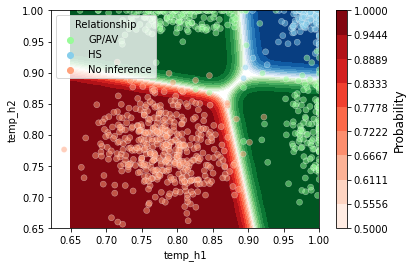

In [64]:
p = PedSims("/Users/cole/Desktop/brown/ponderosa/Untitled/")
p.add_fam()
p.load_ibd()
p.analyze_ibd(3500, 3500)


In [66]:
famG, ibd, root_nodes = p.get_items()

In [67]:
famG.nodes[('hs1_g2-b1-i1', 'hs1_g2-b2-i1')]

{'id1': 'hs1_g2-b1-i1',
 'id2': 'hs1_g2-b2-i1',
 'rel': 'MHS',
 'k': 1691.0443987704575,
 'data': pedigree_tools.pair_data}

In [68]:
temp = []
couple_inlaw = []
for node, node_data in famG.nodes.items():
    rel = node_data["rel"]
    if rel in ["couple", "inlaws"]:
        node_data = node_data["data"]
        couple_inlaw.append([node, rel, node_data.tot_cov, node_data.tot_all, node_data.n_segs, "sim"])
        continue
    node_data = node_data["data"]
    temp.append([node, rel, node_data.tot_cov, node_data.tot_all, node_data.n_segs, "sim"])
data = pd.DataFrame(temp, columns = ["Pair", "Rel", "Tot_cov", "Tot_all", "n_segs", "dtype"])
couple_inlaw = pd.DataFrame(couple_inlaw, columns = ["Pair", "Rel", "Tot_cov", "Tot_all", "n_segs", "dtype"])

In [69]:
t = couple_inlaw[couple_inlaw.Pair.apply(lambda x: "grandparent67" in x[0])].sort_values("Tot_all")
t

,Pair,Rel,Tot_cov,Tot_all,n_segs,dtype
1314,"(grandparent67_g1-b1-i1, grandparent67_g1-b1-s1)",couple,241.481809,241.611756,37,sim
1316,"(grandparent67_g1-b1-i1, grandparent67_g2-b1-s1)",inlaws,302.641566,309.095950,45,sim
1315,"(grandparent67_g2-b1-i1, grandparent67_g2-b1-s1)",couple,1044.387623,1108.980201,56,sim
1317,"(grandparent67_g1-b1-s1, grandparent67_g2-b1-s1)",inlaws,1762.075117,1889.956411,61,sim


In [70]:
t = couple_inlaw[couple_inlaw.Pair.apply(lambda x: "grandparent67" in x[0])].sort_values("Tot_all")
t

,Pair,Rel,Tot_cov,Tot_all,n_segs,dtype
1314,"(grandparent67_g1-b1-i1, grandparent67_g1-b1-s1)",couple,241.481809,241.611756,37,sim
1316,"(grandparent67_g1-b1-i1, grandparent67_g2-b1-s1)",inlaws,302.641566,309.095950,45,sim
1315,"(grandparent67_g2-b1-i1, grandparent67_g2-b1-s1)",couple,1044.387623,1108.980201,56,sim
1317,"(grandparent67_g1-b1-s1, grandparent67_g2-b1-s1)",inlaws,1762.075117,1889.956411,61,sim


In [71]:
data[data["Pair"].apply(lambda x: "grandparent67" in x[0] if not type(x) == float else False)]

,Pair,Rel,Tot_cov,Tot_all,n_segs,dtype
366,"(grandparent67_g1-b1-i1, grandparent67_g3-b1-i1)",MGP,1493.98294,1570.283431,52,sim


In [72]:
data[data["Pair"].apply(lambda x: "grandparent67" in x[0] if not type(x) == float else False)]

,Pair,Rel,Tot_cov,Tot_all,n_segs,dtype
366,"(grandparent67_g1-b1-i1, grandparent67_g3-b1-i1)",MGP,1493.98294,1570.283431,52,sim


In [73]:
import itertools as it
def sim_av(z1, z2, z3):
    def ibd_type(gt1, gt2):
        i, j = 0, 0
        if gt1[0] == gt2[0] or gt1[0] == gt2[1]:
            i += 1
        if gt1[1] == gt2[0] or gt1[1] == gt2[1]:
            i += 1
        if gt2[0] == gt1[0] or gt2[0] == gt1[1]:
            j += 1
        if gt2[1] == gt1[0] or gt2[1] == gt1[1]:
            j += 1
        if i == 2 and j == 2:
            return 2
        if i >= 1 or j >= 1:
            return 1
        return 0
    ibd = {"gp1": [0, 0, 0], "gp2": [0, 0, 0], "av": [0, 0, 0], "sib": [0, 0, 0]}
    for _ in range(10000):
        gp1 = [0, 1]
        gp2 = [np.random.choice([0, 1, 2], p = [z1/2, z1/2, 1 - z1]), 3]
        child1 = [np.random.choice(gp1), np.random.choice(gp2)]
        child2 = [np.random.choice(gp1), np.random.choice(gp2)]
        sp = [np.random.choice(gp1 + [4], p = [z2/2, z2/2, 1 - z2]), np.random.choice(gp2 + [5], p = [z3/2, z3/2, 1 - z3])]
        niece = [np.random.choice(sp), np.random.choice(child1)]
        ibd["gp1"][ibd_type(gp1, niece)] += 1
        ibd["gp2"][ibd_type(gp2, niece)] += 1
        ibd["av"][ibd_type(child2, niece)] += 1
        ibd["sib"][ibd_type(child2, child1)] += 1
    for rel, d in ibd.items():
        ibd1 = d[1] / sum(d)
        ibd2 = d[2] / sum(d)
        print(rel, f"IBD1: {ibd1}, IBD2: {ibd2}, IBD cov: {ibd1+ibd2}, Tot IBD: {ibd2*2 + ibd1}")

# .544, 0.575
sim_av(184.770776/3346.298892, 242.314089/3346.298892, 1386.234076/3346.298892)


gp1 IBD1: 0.5177, IBD2: 0.0126, IBD cov: 0.5303, Tot IBD: 0.5429
gp2 IBD1: 0.5672, IBD2: 0.0512, IBD cov: 0.6184000000000001, Tot IBD: 0.6696000000000001
av IBD1: 0.5423, IBD2: 0.0289, IBD cov: 0.5712, Tot IBD: 0.6001
sib IBD1: 0.5198, IBD2: 0.2467, IBD cov: 0.7665000000000001, Tot IBD: 1.0132


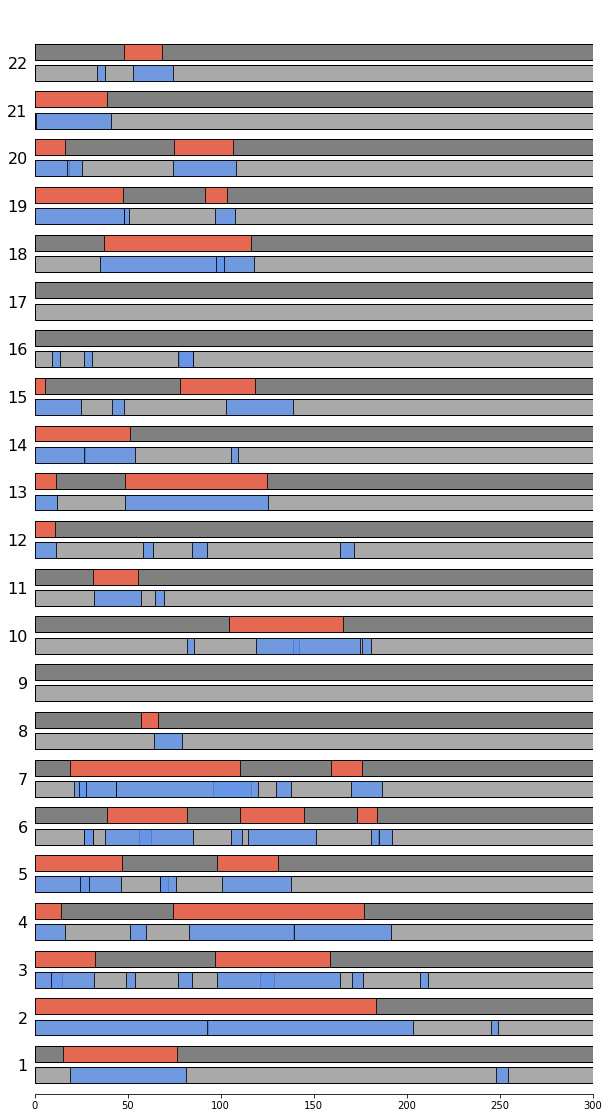

<ipython-input-74-5d7dfb592122>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_ibd["hap"] = 0
<ipython-input-74-5d7dfb592122>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_ibd["chromosome"] = temp_ibd["chromosome"].apply(int)


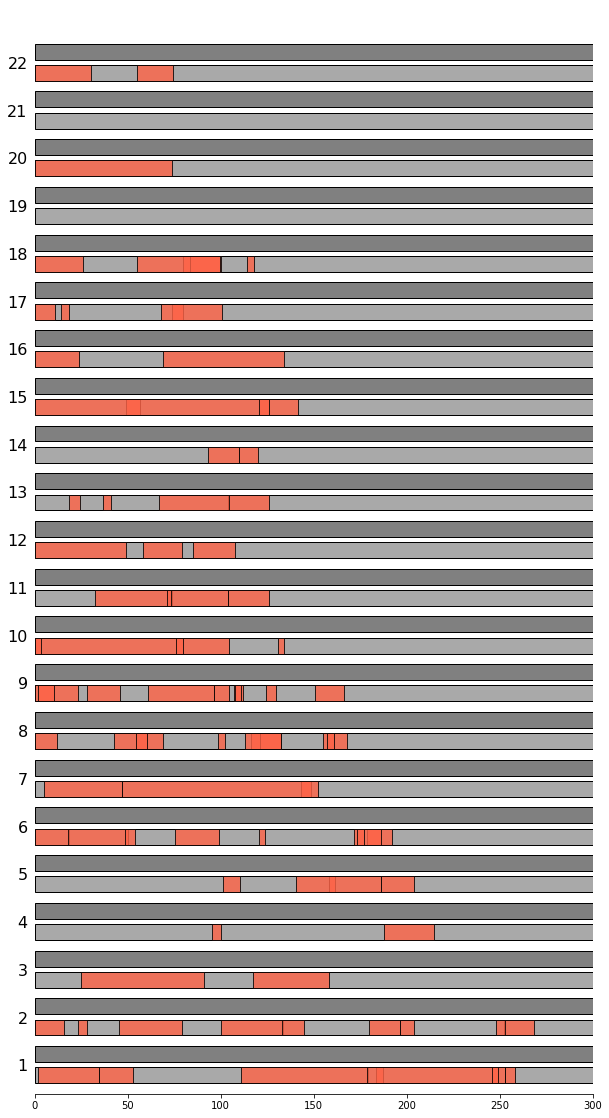

In [74]:
temp_ibd = ibd.get_edge_data("grandparent67_g1-b1-i1", "grandparent67_g3-b1-i1")["ibd"]
k = Karyogram("/Users/cole/Desktop/brown/ponderosa/Untitled/temp.map")
temp_ibd["hap"] = 0
temp_ibd["chromosome"] = temp_ibd["chromosome"].apply(int)
segs = [[1.0, 15.403812, 76.596144, 1.0], [2.0, 0.0, 183.494403, 1.0], [3.0, 0.0, 32.542726, 1.0], [3.0, 96.901518, 158.524606, 1.0], [4.0, 0.0, 14.047837, 1.0], [4.0, 74.598488, 177.053295, 1.0], [5.0, 0.0, 46.93578, 1.0], [5.0, 98.059777, 130.912321, 1.0], [6.0, 38.801279, 82.10806, 1.0], [6.0, 110.272501, 144.692642, 1.0], [6.0, 173.419295, 183.835697, 1.0], [7.0, 18.989853, 110.171643, 1.0], [7.0, 159.352491, 176.04137, 1.0], [8.0, 57.292064, 66.324767, 1.0], [10.0, 104.453474, 165.630162, 1.0], [11.0, 31.319342, 55.567745, 1.0], [12.0, 0.0, 11.155502, 1.0], [13.0, 0.0, 11.524339, 1.0], [13.0, 48.541884, 125.098764, 1.0], [14.0, 0.0, 51.475446, 1.0], [15.0, 0.0, 5.525096, 1.0], [15.0, 78.27029, 118.431046, 1.0], [18.0, 37.238837, 116.434245, 1.0], [19.0, 0.0, 47.216097, 1.0], [19.0, 91.72944, 103.571793, 1.0], [20.0, 0.0, 16.302364, 1.0], [20.0, 74.893298, 106.796702, 1.0], [21.0, 0.0, 38.662722, 1.0], [22.0, 47.949478, 68.664959, 1.0]]
segs += temp_ibd[["chromosome", "start_cm", "end_cm", "hap"]].values.tolist()
k.plot_segments(segs)
plt.show()

# temp_ibd = ibd.get_edge_data("grandparent67_g1-b1-s1", "grandparent67_g3-b1-i1")["ibd"]
temp_ibd = temp_segs[temp_segs.PAIR_ID == "HMB006_HMB008"]
k = Karyogram("/Users/cole/Desktop/brown/ponderosa/Untitled/temp.map")
temp_ibd["hap"] = 0
temp_ibd["chromosome"] = temp_ibd["chromosome"].apply(int)
k.plot_segments(temp_ibd[["chromosome", "start_cm", "end_cm", "hap"]].values, hap0_color = "tomato")
plt.show()

In [75]:
pair_data = {}
data = data[data.dtype != "real"]
p = PedSims("/Users/cole/Desktop/brown/ponderosa/Untitled/")


for (id1, id2, pair_id), pair_df in himba_segs.groupby(["id1", "id2", "PAIR_ID"]):
    pair_df["l"] = pair_df["end_cm"] - pair_df["start_cm"]
    pair_data[pair_id] = p.pair_segments(id1, id2, pair_df, 1)
    
second_pairs = pairs_df[pairs_df.GTD & (pairs_df.REL.isin(["MHS", "PHS", "MGP", "PGP", "AV"]))].copy()
second_pairs["n_segs"] = pairs_df.apply(lambda x: np.nan if x.PAIR_ID not in pair_data else pair_data[x.PAIR_ID].n_segs, axis = 1)
second_pairs["Tot_all"] = pairs_df.apply(lambda x: np.nan if x.PAIR_ID not in pair_data else pair_data[x.PAIR_ID].tot_all, axis = 1)
second_pairs["Tot_cov"] = pairs_df.apply(lambda x: np.nan if x.PAIR_ID not in pair_data else pair_data[x.PAIR_ID].tot_cov, axis = 1)

second_pairs["Rel"] = second_pairs["REL"]


second_pairs["dtype"] = "real"
data = pd.concat([data, second_pairs[["Rel", "Tot_cov", "Tot_all", "n_segs", "dtype"]]])


In [76]:
s = temp_segs[temp_segs.PAIR_ID=="HMB004_HMB005"]
s["l"] = s["end_cm"] - s["start_cm"]
p.pair_segments("HMB004", "HMB005", s).tot_cov

<ipython-input-76-4b0b7babc8a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s["l"] = s["end_cm"] - s["start_cm"]


3533.3471111382396

In [77]:
data

,Pair,Rel,Tot_cov,Tot_all,n_segs,dtype
0,"(hs1_g2-b1-i1, hs1_g2-b2-i1)",MHS,1607.948462,1691.044399,60.0,sim
1,"(hs2_g2-b1-i1, hs2_g2-b2-i1)",MHS,2148.579458,2379.438408,57.0,sim
2,"(hs3_g2-b1-i1, hs3_g2-b2-i1)",MHS,1960.245721,2116.628305,59.0,sim
3,"(hs4_g2-b1-i1, hs4_g2-b2-i1)",MHS,1729.640410,1784.133080,59.0,sim
4,"(hs5_g2-b1-i1, hs5_g2-b2-i1)",MHS,2344.470418,2644.534375,58.0,sim
...,...,...,...,...,...,...
5230,NaN,MGP,1791.518875,1891.879864,47.0,real
5233,NaN,MGP,1958.215291,2092.001349,49.0,real
5236,NaN,PGP,2108.241486,2233.447641,45.0,real
5237,NaN,MGP,2189.282833,2306.369262,52.0,real


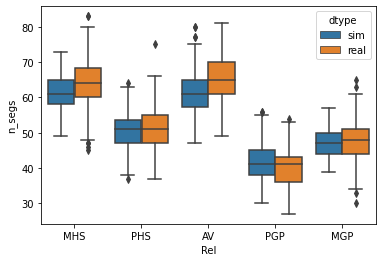

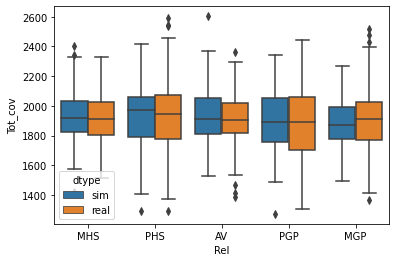

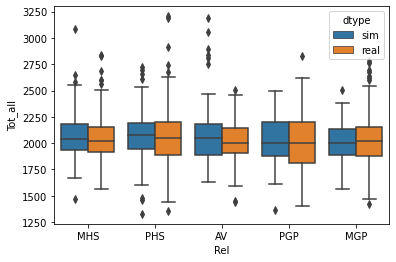

In [78]:
data["k"] = data[["Tot_cov","dtype"]].apply(lambda x: x[0] / (3500 if x[1] == "real" else 2605), axis = 1)

sns.boxplot(data = data, x = "Rel", y = "n_segs", hue = "dtype")
plt.show()

sns.boxplot(data = data, x = "Rel", y = "Tot_cov", hue = "dtype")
plt.show()

sns.boxplot(data = data, x = "Rel", y = "Tot_all", hue = "dtype")
plt.show()



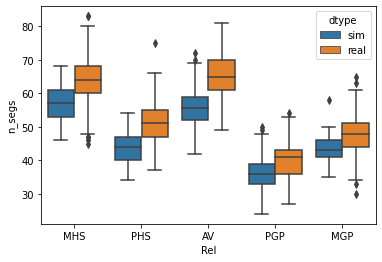

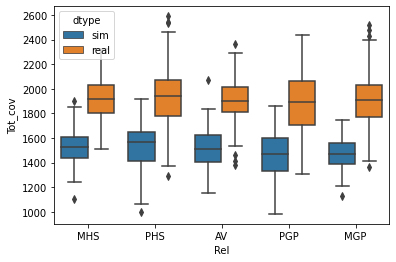

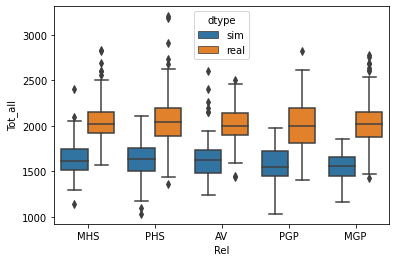

In [37]:
data["k"] = data[["Tot_cov","dtype"]].apply(lambda x: x[0] / (3500 if x[1] == "real" else 2605), axis = 1)

sns.boxplot(data = data, x = "Rel", y = "n_segs", hue = "dtype")
plt.show()

sns.boxplot(data = data, x = "Rel", y = "Tot_cov", hue = "dtype")
plt.show()

sns.boxplot(data = data, x = "Rel", y = "Tot_all", hue = "dtype")
plt.show()



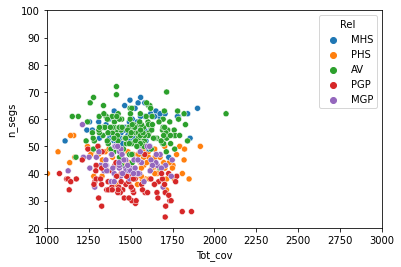

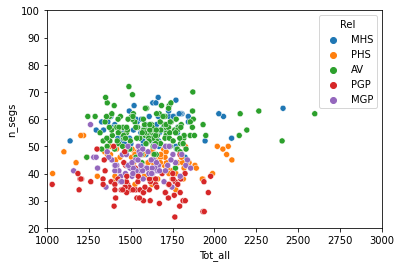

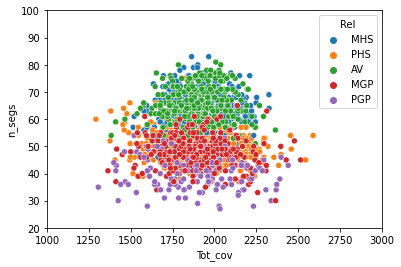

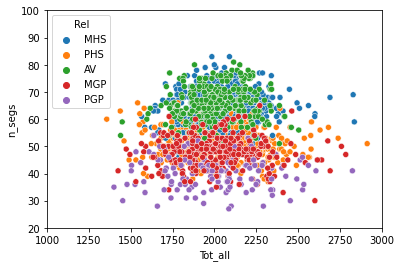

In [29]:
sns.scatterplot(data = data[data.dtype == "sim"], x = "Tot_cov", y = "n_segs", hue = "Rel")
plt.xlim(1000, 3000)
plt.ylim(20, 100)
plt.show()

sns.scatterplot(data = data[data.dtype == "sim"], x = "Tot_all", y = "n_segs", hue = "Rel")
plt.xlim(1000, 3000)
plt.ylim(20, 100)
plt.show()

sns.scatterplot(data = data[data.dtype == "real"], x = "Tot_cov", y = "n_segs", hue = "Rel")
plt.xlim(1000, 3000)
plt.ylim(20, 100)
plt.show()

sns.scatterplot(data = data[data.dtype == "real"], x = "Tot_all", y = "n_segs", hue = "Rel")
plt.xlim(1000, 3000)
plt.ylim(20, 100)
plt.show()

In [30]:
second_pairs

,PAIR_ID,IID1,IID2,GTD,IBD1,IBD2,PIHAT,KINGINF,REL,DEGREE,n_segs,Tot_all,Tot_cov,Rel,dtype
0,HMB004_HMB856,HMB004,HMB856,True,0.5086,0.0032,0.2575,2nd,MHS,2nd,69.0,1861.173126,1753.716542,MHS,real
1,HMB004_HMB2970,HMB004,HMB2970,True,0.5057,0.0180,0.2709,2nd,MHS,2nd,59.0,1975.339291,1854.587529,MHS,real
3,HMB005_HMB013,HMB005,HMB013,True,0.5922,0.0177,0.3138,2nd,PHS,2nd,54.0,2384.232410,2212.436771,PHS,real
4,HMB005_HMB1037,HMB005,HMB1037,True,0.5585,0.0072,0.2864,2nd,PHS,2nd,57.0,2157.275433,2002.821201,PHS,real
5,HMB005_HMB1051,HMB005,HMB1051,True,0.5372,0.0085,0.2771,2nd,PHS,2nd,54.0,2073.716844,1868.496928,PHS,real
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5230,HMB411_HMB995,HMB995,HMB411,True,0.4881,0.0040,0.2481,2nd,MGP,2nd,47.0,1891.879864,1791.518875,MGP,real
5233,HMB411_HMB997,HMB997,HMB411,True,0.5521,0.0083,0.2843,2nd,MGP,2nd,49.0,2092.001349,1958.215291,MGP,real
5236,HMB3119_HMB999,HMB999,HMB3119,True,0.5983,0.0065,0.3057,2nd,PGP,2nd,45.0,2233.447641,2108.241486,PGP,real
5237,HMB060_HMB999,HMB999,HMB060,True,0.6338,0.0090,0.3259,2nd,MGP,2nd,52.0,2306.369262,2189.282833,MGP,real


In [31]:
pairs_df = pd.read_csv("/Users/cole/Desktop/brown/ponderosa/Himba_pairs.txt", delim_whitespace = True)
pairs_df[pairs_df.REL == "GP"]



,PAIR_ID,IID1,IID2,GTD,IBD1,IBD2,PIHAT,KINGINF,REL,DEGREE
3722,HMB005_HMB008,HMB005,HMB008,True,0.5531,0.0134,0.2900,2nd,GP,2nd
3725,HMB006_HMB008,HMB006,HMB008,True,0.5106,0.0104,0.2657,2nd,GP,2nd
3729,HMB010_HMB2991,HMB010,HMB2991,True,0.4530,0.0044,0.2309,2nd,GP,2nd
3730,HMB010_HMB095,HMB010,HMB095,True,0.5908,0.0046,0.3000,2nd,GP,2nd
3733,HMB013_HMB2991,HMB013,HMB2991,True,0.5288,0.0115,0.2759,2nd,GP,2nd
...,...,...,...,...,...,...,...,...,...,...
5232,HMB997_Missing019,HMB997,Missing019,False,NaN,NaN,NaN,NaN,GP,2nd
5233,HMB411_HMB997,HMB997,HMB411,True,0.5521,0.0083,0.2843,2nd,GP,2nd
5236,HMB3119_HMB999,HMB999,HMB3119,True,0.5983,0.0065,0.3057,2nd,GP,2nd
5237,HMB060_HMB999,HMB999,HMB060,True,0.6338,0.0090,0.3259,2nd,GP,2nd


In [218]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib as mpl
from collections import Counter

class PedigreeHierarchy:
    
    def __init__(self):
        
        hier = [["relatives", "1st"],
                ["relatives", "2nd"],
                ["relatives", "3rd"],
                ["relatives", "4th"],
                ["relatives", "MZ"],
                ["1st", "PO"],
                ["1st", "FS"],
                ["2nd", "GP/AV"],
                ["GP/AV", "GP"],
                ["GP", "MGP"],
                ["GP", "PGP"],
                ["2nd", "DCO"],
                ["2nd", "HS"],
                ["HS", "MHS"],
                ["HS", "PHS"],
                ["GP/AV", "AV"],
                ["3rd", "CO"],
                ["3rd", "DHCO"],
                ["3rd", "GGP"],
                ["GGP", "MGGP"],
                ["GGP", "PGGP"],
                ["3rd", "HAV"],
                ["HAV", "MHAV1"],
                ["HAV", "MHAV2"],
                ["HAV", "PHAV1"],
                ["HAV", "PHAV2"],
                ["4th", "HCO"],
                ["HCO", "MHCO"],
                ["HCO", "PHCO"],
                ["4th", "CORM"],
                ["4th", "GGGP"]]
            
        self.hier = nx.DiGraph()

        self.hier.add_nodes_from([(node, {"p": int(node == "relatives"), "p_con": int(node == "relatives"), "method": "None"}) for node in it.chain(*hier)])
        self.hier.add_edges_from(hier)

        self.init_nodes = set(it.chain(*hier))

        print(self.hier.nodes["relatives"])

    ### This set of functions is for holding/managing/plotting the hierarchy for a pair of individuals
    ##################################################################################################

    def add_probs(self, node, **kwargs):
        # a list of probs has been provided, not a single node
        if type(node) == list:
            add_list = node[:]
        # information for a single node has been provided (along with other pos args); convert to a list    
        else:
            add_list = [[node, kwargs["p_con"], kwargs["method"]]]

        # add the new information
        for node, p, method in add_list:
            self.hier.nodes[node]["p_con"] = p
            self.hier.nodes[node]["method"] = method
        
    # after all probabilities have been added, cascade the probabilities down the tree
    def compute_probs(self):
        # iterate through each node in a breadthfirst order
        for parent in nx.bfs_tree(self.hier, "relatives"):

            # get the child nodes of the parent node
            children = nx.descendants_at_distance(self.hier, parent, 1)
            
            # sum the probability of the all the children for rescaling
            p = np.nansum([self.hier.nodes[node]["p_con"] for node in children])

            if p == 0:
                continue
            
            # for each child, rescale the conditional probability and compute the probability by multiply the conditional by the prob of the parent
            for node in children:
                self.hier.nodes[node]["p_con"] /= p
                self.hier.nodes[node]["p"] = self.hier.nodes[node]["p_con"]*self.hier.nodes[parent]["p"]

    # starting at the root, traverses the path of most probable relationships until it reaches a probability below min_p
    def most_probable(self, min_p):
        
        max_node, max_p = "relatives", 1

        while True:

            # iterate through the children and keep track of their probs
            probable_children = [(-1, None)]
            for node in nx.descendants_at_distance(self.hier, max_node, 1):
                probable_children.append([self.hier.nodes[node]["p"], node])

            # sort the children by their probability
            probable_children.sort(key=lambda x: x[0], reverse=True)

            # get the highest prob of the current children
            cur_p = probable_children[0][0]

            # only continue if the current p is greater than the min
            if cur_p < min_p:
                break

            max_p, max_node = probable_children[0]

        return max_node, max_p
 
    # plots the hierarchy and the associated probabilities
    def plot_hierarchy(self, in_g, min_display_p=-1):

        # remove nodes where the prob is below a certain probability
        keep_nodes = [node for node, attr in in_g.nodes(data=True) if attr["p"] > min_display_p]

        print(keep_nodes)
        g = in_g.subgraph(sorted(keep_nodes))

        # get the position of the nodes
        pos = graphviz_layout(g, prog='dot')

        # get max number of nodes per level
        level_size = Counter([y_coord for _,(_, y_coord) in pos.items()])
        max_width = sorted([num for _, num in level_size.items()], reverse=True)[0]

        # set the size of the plot according to the max width of the tree
        f, ax = plt.subplots(figsize=(1.8*max_width, 1.8*max_width))

        # draw the edges
        for i, j in g.edges:
            x1, y1 = pos[i]; x2, y2 = pos[j]
            ax.plot([x1, x2], [y1, y2], color="black", zorder=0)

        # colormap used for choosing the color of the nodes
        cmap = mpl.colormaps['autumn_r'].resampled(8)

        # add the probabilities
        for node, coords in pos.items():
            pos[node] = list(coords) + [g.nodes[node]["p"], g.nodes[node]["p_con"], g.nodes[node]["method"]]

        # plot the nodes and their probabilities
        for lab, (x, y, p, p_con, method) in pos.items():
            ax.text(x, y, lab + f"\n{round(p, 3)}\n{method}\n{round(p_con, 3)}", color="black", va='center', ha='center', 
            bbox=dict(edgecolor=cmap(float(p)), facecolor='white', boxstyle='round'))

        # minor graph aspects
        ax.set_aspect(1)
        ax.axis('off')

    # plots the probability tree for the degree
    def plot_degree(self, show_zero_p):

        g = self.hier.subgraph(nx.descendants_at_distance(self.hier, "relatives", 1) | {"relatives"})

        self.plot_hierarchy(g, -1 if show_zero_p else 0.0)

    # plots the probability tree for second degree relatives
    def plot_second(self, show_zero_p):

        g = self.hier.subgraph(nx.descendants(self.hier, "2nd") | {"2nd"})

        self.plot_hierarchy(g, -1 if show_zero_p else 0.0)

    # plots the entire hierarchy
    def plot_all(self, show_zero_p):

        self.plot_hierarchy(self.hier, -1 if show_zero_p else 0.0)

    ### This set of functions is for holding pairs known relatives
    ##################################################################################################

    # adds a pair of relatives
    def add_pair(self, pair, rel, attrs):
        # add the edge
        self.hier.add_edge(rel, pair)

        # add the pair attributes
        for attr, attr_val in attrs.items():
            self.hier.nodes[pair][attr] = attr_val

    # add pairs from a list of individuals
    def add_pairs_from(self, pair_list):
        for pair, rel, attrs in pair_list:
            self.add_pair(pair, rel, attrs)

    # given a relationship, returns the the relative pairs under that relationship
    def get_pairs(self, node):
        return nx.descendants(self.hier, node) - self.init_nodes
    
    # given a parent node, returns a df with all the descendant nodes and all attributes they have as columns
    def get_pair_df(self, node):

        # get the pairs who are descendant pairs
        pair_list = list(self.get_pairs(node))

        # holds all columns and column values
        columns = {"pair": pair_list,
                   "degree": [nx.shortest_path(self.hier, "relatives", node)[1] for node in pair_list],
                   "rel": [next(self.hier.predecessors(node)) for node in pair_list]}

        # iterate through each person and add
        for index, pair in enumerate(pair_list):
            for attr, val in self.hier.nodes[pair].items():
                # attribute does not exist yet, so add it
                if attr not in columns:
                    columns[attr] = list(np.arange(len(pair_list)) * np.nan)

                # add the attribute
                columns[attr][index] = val

        return pd.DataFrame(columns)

    def get_relative_nodes(self, node, include=False):
        return (nx.descendants(self.hier, node) & self.init_nodes) | ({node} if include else set())

    # given a list of relationship nodes, returns all pairs under
    def get_nodes_from_list(self, node_list):
        return set(it.chain(*[list(self.get_pairs(node)) for node in node_list]))
    

{'p': 1, 'p_con': 1, 'method': 'None'}
{'p': 1, 'p_con': 1, 'method': 'None'}
{'p': 1, 'p_con': 1, 'method': 'None'}
{'p': 1, 'p_con': 1, 'method': 'None'}
['relatives', '1st', '2nd', '3rd', '4th', 'MZ', 'PO', 'FS', 'GP/AV', 'GP', 'MGP', 'PGP', 'DCO', 'HS', 'MHS', 'PHS', 'AV', 'CO', 'DHCO', 'GGP', 'MGGP', 'PGGP', 'HAV', 'MHAV1', 'MHAV2', 'PHAV1', 'PHAV2', 'HCO', 'MHCO', 'PHCO', 'CORM', 'GGGP']


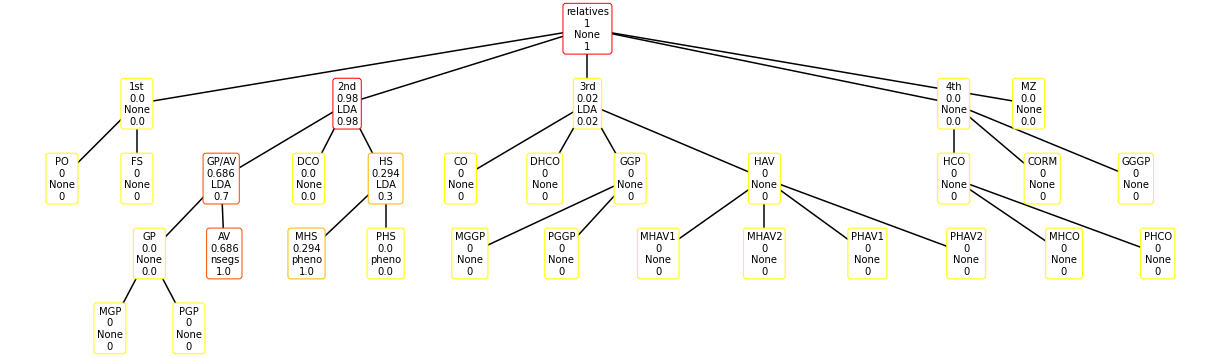

In [219]:
h = PedigreeHierarchy()
print(h.hier.nodes["relatives"])
h.add_probs([("2nd", 0.98, "LDA"), ("3rd", 0.02, "LDA"), ("HS", 0.3, "LDA"), ("PHS", 0, "pheno"), ("MHS", 0.5, "pheno"), ("AV", 0.3, "nsegs"), ("GP/AV", 0.7, "LDA")])
print(h.hier.nodes["relatives"])
h.compute_probs()
print(h.hier.nodes["relatives"])
h.most_probable(0.5)
h.plot_all(True)
# h.plot_degree(False)

In [217]:
h = PedigreeHierarchy()
h.add_pairs_from([[("A", "B"), "PHS", {"ibd1": 0.5, "ibd2": 0.25}], [("A", "C"), "MHS", {"ibd1": 0.49}], [("A", "D"), "CO", {}]])
h.get_nodes_from_list(["MHS", "PHS"])

{'p': 1, 'p_con': 1, 'method': 'None'}


{('A', 'B'), ('A', 'C')}

In [171]:
nx.shortest_path(h.hier, "relatives", "MHS")


['relatives', '2nd', 'HS', 'MHS']

In [14]:
# def plot_tree(g):

#     depth = 0
#     level = ["relatives"]



#     while len(level) > 0:
#         level.sort()
#         print(level)

#         for r, x in zip(level, np.linspace(0, 10, len(level))):
#             plt.text(x, 10-depth, r)

        

#         level = list(it.chain(*[[child for child, l in nx.single_source_shortest_path_length(g, node, 1).items() if l==1] for node in level]))
#         depth += 1


    
# plot_tree(h.hier)

In [10]:
g = nx.DiGraph()
g.add_nodes_from([(1, {"a":1})])
g.add_edges_from([[1,2],[5,4]])

nx.descendants(g, 1)

{2}

[('relatives', {'p': 1, 'p_con': 1}), ('1st', {'p': 0.0, 'p_con': 0.0}), ('2nd', {'p': 0.98, 'p_con': 0.98}), ('3rd', {'p': 0.02, 'p_con': 0.02}), ('4th', {'p': 0.0, 'p_con': 0.0}), ('MZ', {'p': 0.0, 'p_con': 0.0}), ('PO', {'p': 0, 'p_con': 0}), ('FS', {'p': 0, 'p_con': 0}), ('GP/AV', {'p': 0.6859999999999999, 'p_con': 0.7}), ('GP', {'p': 0.4801999999999999, 'p_con': 0.7}), ('MGP', {'p': 0.04801999999999999, 'p_con': 0.1}), ('PGP', {'p': 0.4321799999999999, 'p_con': 0.9}), ('DCO', {'p': 0.0, 'p_con': 0.0}), ('HS', {'p': 0.294, 'p_con': 0.3}), ('MHS', {'p': 0.294, 'p_con': 1.0}), ('PHS', {'p': 0.0, 'p_con': 0.0}), ('AV', {'p': 0.20579999999999998, 'p_con': 0.3}), ('CO', {'p': 0, 'p_con': 0}), ('DHCO', {'p': 0, 'p_con': 0}), ('GGP', {'p': 0, 'p_con': 0}), ('MGGP', {'p': 0, 'p_con': 0}), ('PGGP', {'p': 0, 'p_con': 0}), ('HAV', {'p': 0, 'p_con': 0}), ('MHAV1', {'p': 0, 'p_con': 0}), ('MHAV2', {'p': 0, 'p_con': 0}), ('PHAV1', {'p': 0, 'p_con': 0}), ('PHAV2', {'p': 0, 'p_con': 0}), ('HCO', {

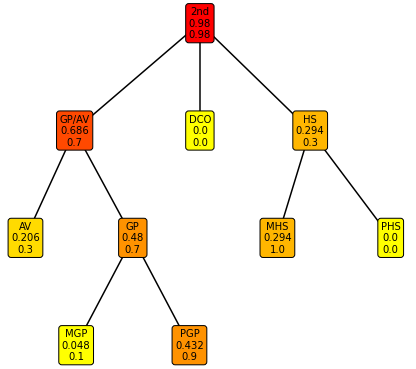

In [77]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib as mpl
from collections import Counter

g = h.hier.copy()


def plot_hierarchy(in_g, min_display_p=-1):

    # remove nodes where the prob is below a certain probability
    keep_nodes = [node for node, attr in in_g.nodes(data=True) if attr["p"] > min_display_p]
    g = in_g.subgraph(keep_nodes)

    # get the position of the nodes
    pos = graphviz_layout(g.subgraph(keep_nodes), prog='dot')

    # get max number of nodes per level
    level_size = Counter([y_coord for _,(_, y_coord) in pos.items()])
    max_width = sorted([num for _, num in level_size.items()], reverse=True)[0]

    # set the size of the plot according to the max width of the tree
    f, ax = plt.subplots(figsize=(1.8*max_width, 1.8*max_width))

    # draw the edges
    for i, j in g.edges:
        x1, y1 = pos[i]; x2, y2 = pos[j]
        ax.plot([x1, x2], [y1, y2], color="black", zorder=0)

    # colormap used for choosing the color of the nodes
    cmap = mpl.colormaps['autumn_r'].resampled(8)

    # add the probabilities
    for node, coords in pos.items():
        print(g.nodes[node])
        pos[node] = list(coords) + [g.nodes[node]["p"], g.nodes[node]["p_con"]]

    # plot the nodes and their probabilities
    for lab, (x, y, p, p_con) in pos.items():
        ax.text(x, y, lab + f"\n{round(p, 3)}\n{round(p_con, 3)}", color="black", va='center', ha='center', 
        bbox=dict(facecolor=cmap(float(p)), edgecolor='black', boxstyle='round'))

    # minor graph aspects
    ax.set_aspect(1)
    ax.axis('off')

h = PedigreeHierarchy()
h.hier.nodes(data=True)
h.add_probs([("2nd", 0.98), ("3rd", 0.02), ("HS", 0.3), ("PHS", 0), ("MHS", 0.5), ("AV", 0.3), ("GP/AV", 0.7), ("GP", 0.7), ("MGP", 0.1), ("PGP", 0.9)])
h.compute_probs()
h.hier.nodes(data=True)

g = h.hier.copy()
print(g.nodes(data=True))
plot_hierarchy(g.subgraph(nx.descendants(g, "2nd") | {"2nd"}))


In [36]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

viridis = mpl.colormaps['autumn_r'].resampled(8)

In [78]:
pair_df = pd.read_csv("../PedigreeSimulations/SA_sims/av/segments.txt", delim_whitespace=True)
pair_df



,"chromosome,id1,id2,id1_haplotype,id2_haplotype,start,end,start_cm,end_cm,start_bp,end_bp,new,fid1,fid2,rel,degree,iteration"
0,"1,av52_g2-b1-i1,av52_g2-b2-i1,0,0,0,529,0.0722..."
1,"1,av93_g2-b1-i1,av93_g2-b2-i1,0,0,77,492,0.485..."
2,"1,av90_g3-b1-i1,av90_g4-b1-i1,0,1,0,1029,0.072..."
3,"1,av132_g2-b1-i1,av132_g2-b2-i1,1,1,293,613,2...."
4,"1,av42_g2-b1-i1,av42_g2-b2-i1,1,1,0,795,0.0722..."
...,...
52216,"22,av205_g2-b2-i1,av205_g3-b1-i1,1,0,1189,1888..."
52217,"22,av205_g3-b1-i1,av205_g3-b2-i1,0,0,1945,5247..."
52218,"22,av205_g3-b1-i1,av205_g4-b1-i1,0,1,3456,7801..."
52219,"22,av205_g3-b1-i1,av205_g4-b1-i1,1,1,0,3508,0...."


In [15]:
pair_df = pd.read_csv("../PedigreeSimulations/Himba2nd_sims/av/segments.txt", sep=" ")


pair_df["l"] = pair_df.end_cm - pair_df.start_cm

pair_df = pd.concat([tmp for _, tmp in pair_df.groupby(["id1", "id2"]) if tmp["l"].sum() < 2000])

pair_df = pair_df[pair_df.rel=="AV"]
pair_df

,chromosome,id1,id2,id1_haplotype,id2_haplotype,start,end,start_cm,end_cm,start_bp,end_bp,fid1,fid2,rel,degree,l
34007,1,av102_g2-b2-i1,av102_g3-b1-i1,0,1,8017,11970,84.323986,117.795538,59321745,90537317,av102,av102,AV,2nd,33.471552
34160,1,av102_g2-b2-i1,av102_g3-b1-i1,1,1,965,2189,13.377241,28.759669,6232157,14880751,av102,av102,AV,2nd,15.382428
34822,1,av102_g2-b2-i1,av102_g3-b1-i1,0,0,19454,20779,186.133032,196.786030,177629723,189587034,av102,av102,AV,2nd,10.652998
34898,1,av102_g2-b2-i1,av102_g3-b1-i1,0,1,18594,20117,179.489700,191.679460,169498975,183159377,av102,av102,AV,2nd,12.189760
35954,1,av102_g2-b2-i1,av102_g3-b1-i1,0,0,28679,29109,270.689200,275.872628,244877955,246988179,av102,av102,AV,2nd,5.183428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69093,20,av98_g2-b2-i1,av98_g3-b1-i1,1,0,6222,6554,67.609026,71.239242,45244846,46947639,av98,av98,AV,2nd,3.630216
69841,21,av98_g2-b2-i1,av98_g3-b1-i1,0,0,0,4448,0.703245,53.565956,14669931,43444731,av98,av98,AV,2nd,52.862710
70035,22,av98_g2-b2-i1,av98_g3-b1-i1,0,0,0,787,0.948961,15.991643,17119450,22861994,av98,av98,AV,2nd,15.042682
70549,22,av98_g2-b2-i1,av98_g3-b1-i1,0,0,1119,4556,21.970017,60.923075,25612701,47447370,av98,av98,AV,2nd,38.953059


In [16]:
import pickle as pkl
def keep_ibd_regions(pair_df, regions, id_label, inter_phase=False):

    regions = pd.DataFrame(regions, columns=["chromosome", "start", "stop"])

    # stores the new ibd segments
    new_segments = []

    # iterate through each chromosome
    for chrom, chrom_df in pair_df.groupby("chromosome"):

        # only take regions from the chromosome
        chrom_region = regions[regions.chromosome==chrom]

        if chrom_region.shape[0] == 0:
            continue

        # iterate through each segment
        for _, row in chrom_df.iterrows():

            start1, stop1 = row["start_cm"], row["end_cm"]
            

            # now iterate through the coverage regions
            for start2, stop2 in chrom_region[["start", "stop"]].values:
                # there is overlap
                if min(stop1, stop2) - max(start1, start2) > 0:
                    # adjust the stop/stop coordinates
                    new_start = start1 if start2 < start2 else start2
                    new_stop = stop1 if stop2 > stop1 else stop2

                    new_segments.append([chrom, row["id1"], row["id2"], row["id1_haplotype"], row["id2_haplotype"], new_start, new_stop,])

    new_segments = pd.DataFrame(new_segments, columns=["chromosome", "id1", "id2", "id1_haplotype", "id2_haplotype", "start_cm", "end_cm"])
    new_segments["l"] = new_segments.end_cm - new_segments.start_cm

    # now compute the haplotype scores
    tot = new_segments["l"].sum()

    if inter_phase:
        h1 = new_segments[new_segments[f"{id_label}_haplotype"]==0]["l"].sum() / tot if tot > 0 else np.nan

    else:
        h1 = sum([max(chrom_df[chrom_df[f"{id_label}_haplotype"]==0]["l"].sum(), chrom_df[chrom_df[f"{id_label}_haplotype"]==1]["l"].sum()) for _, chrom_df in new_segments.groupby("chromosome")]) / tot if tot > 0 else np.nan

    return h1 if h1 > 0.5 else 1-h1

i = open("relative_phased/regions.pkl", "rb")
d = pkl.load(i)


data = []
for pair, tmp in pair_df.groupby(["id1", "id2"]):
    for id_lab in ["id1", "id2"]:
        data.append([pair, id_lab, "chr1", False, keep_ibd_regions(tmp[tmp.chromosome==1], [[1, 0, 300]], id_lab, False)])
        for p in [True, False]:
            data.append([pair, id_lab, "all", p, keep_ibd_regions(tmp, [[i, 0, 300] for i in range(1, 23)], id_lab, p)])
            for r in ["hs", "co", "hco"]:
                range_list = d[r][np.random.choice(len(d[r]))]
                data.append([pair, id_lab, r, p, keep_ibd_regions(tmp, range_list, id_lab, p)])

    

hap_scores = pd.DataFrame(data, columns=["pair", "id_lab", "rel", "inter_phased", "h1"])

In [87]:
np.random.choice(len(d["co"]))




154

In [68]:
pair = hap_scores[hap_scores.apply(lambda x: x.h1 < 0.7 and x.id_lab=="id2", axis=1)].pair.values[0]

pair_df[pair_df.apply(lambda x: (x.id1, x.id2) == pair, axis=1)]["l"].sum()

3686.4935075185767

/users/cwilli50/.conda/envs/msp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/cwilli50/.conda/envs/msp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/cwilli50/.conda/envs/msp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/cwilli50/.conda/envs/msp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

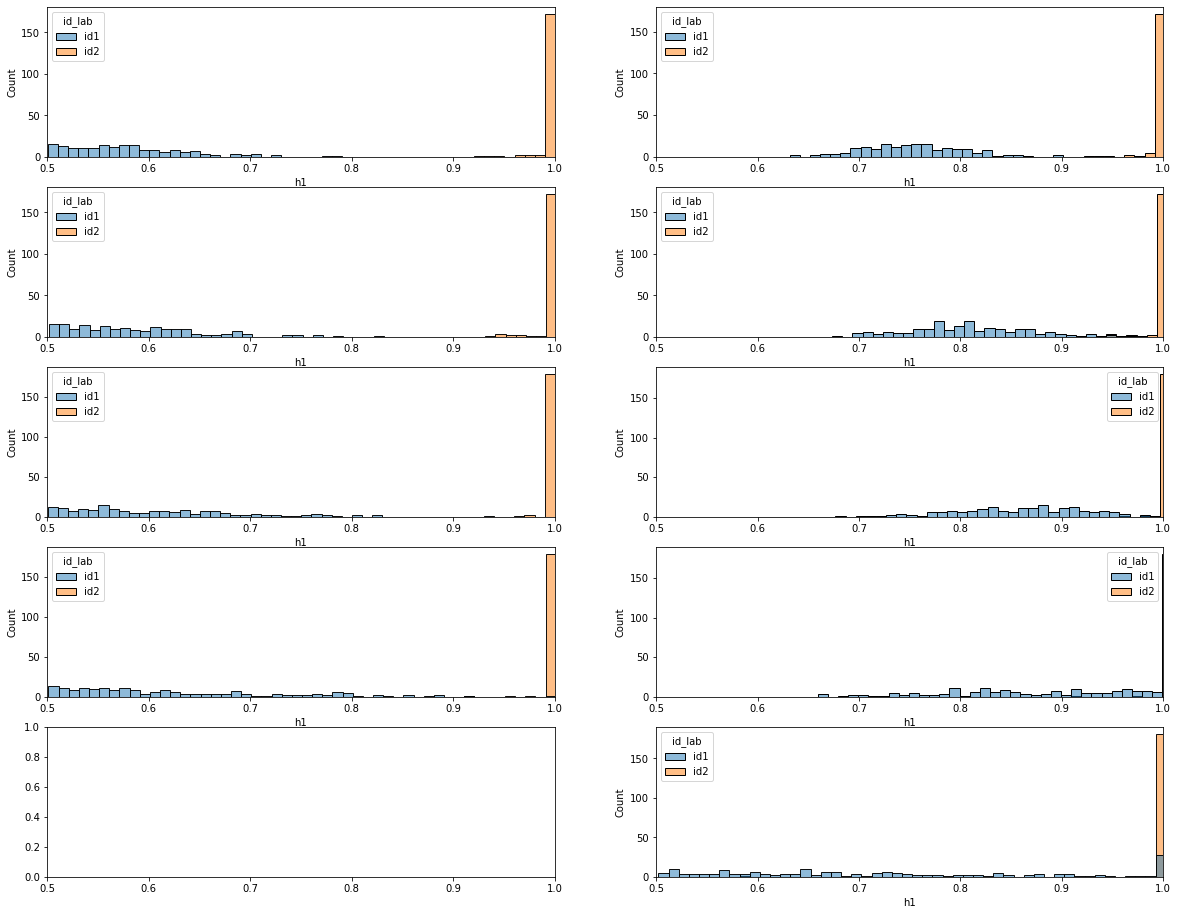

In [81]:
f, axs = plt.subplots(ncols=2, nrows=5, figsize=(20, 16))

for (r, inter), ax in zip(it.product(["all", "hs", "co", "hco", "chr1"], [True, False]), axs.flat):
    
    
    sns.histplot(data=hap_scores[hap_scores.apply(lambda x: x.rel==r and x.inter_phased==inter, axis=1)], x="h1", ax=ax, hue="id_lab", binwidth=0.01)
    ax.title(f"{r} inter={inter}")

    ax.set_xlim(0.5, 1)

In [12]:

data = []
import time
t = time.time()
for rel in ["MGP", "PHS"]:
    i = 0
    pair_df = pd.read_csv(f"../PedigreeSimulations/Himba2nd_sims/{rel.lower()}/segments.txt", sep=" ")
    for pair, tmp in pair_df[pair_df.rel==rel].groupby(["id1", "id2"]):
        tmp = tmp[tmp.chromosome>=1]
        p = ProcessSegments(tmp)
        d = p.ponderosa_data(3500, inter_phase=False)
        data.append((d.ibd1, d.ibd2, d.h1, d.h2, rel))
        i += 1
    print(i, time.time()-t)

# t = time.time()
# i = 0
# pair_df = pd.read_csv("../PedigreeSimulations/Himba_sims/mhs/segments.txt", sep=" ")
# for pair, tmp in pair_df[pair_df.rel=="MHS"].groupby(["id1", "id2"]):
#     tmp = tmp[tmp.chromosome>=1]
#     p = ProcessSegments(tmp)
#     d = p.ponderosa_data(3500, inter_phase=True)
#     data.append((d.ibd1, d.ibd2, d.h1, d.h2, "MHS"))
#     i += 1
# print(i, time.time()-t)

df = pd.DataFrame(data, columns=["ibd1", "ibd2", "h1", "h2", "PHS"])

234 4.548284530639648
141 7.015722274780273


In [6]:
df[["ibd1", "ibd2"]].mean()

ibd1    0.533392
ibd2    0.010688
dtype: float64

/users/cwilli50/.conda/envs/msp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/cwilli50/.conda/envs/msp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/cwilli50/.conda/envs/msp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/cwilli50/.conda/envs/msp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

(0.5, 1.0)

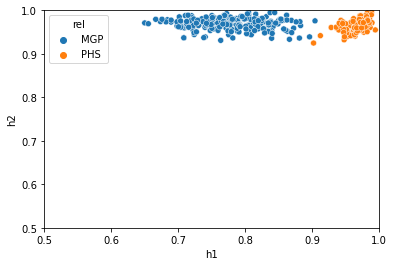

In [13]:
sns.scatterplot(data=pd.DataFrame(data, columns=["ibd1", "ibd2", "h1", "h2", "rel"]), x="h1", y="h2", hue="rel")
plt.xlim(0.5, 1)
plt.ylim(0.5, 1)

In [234]:
pair_df[pair_df.apply(lambda x: x.id1=="av1_g2-b2-i1" and x.id2=="av1_g3-b1-i1", axis=1)]

,chromosome,id1,id2,id1_haplotype,id2_haplotype,start,end,start_cm,end_cm,start_bp,end_bp,new,fid1,fid2,rel,degree,iteration
0,1,av1_g2-b2-i1,av1_g3-b1-i1,1,1,0,685,6.670000e-02,5.721359,752721,3575146,0,av1,av1,AV,2nd,1
27,1,av1_g2-b2-i1,av1_g3-b1-i1,0,1,4282,8477,3.646070e+01,64.928755,18565761,39061771,0,av1,av1,AV,2nd,1
66,1,av1_g2-b2-i1,av1_g3-b1-i1,1,1,2436,4355,2.080636e+01,37.306800,10978767,18789789,0,av1,av1,AV,2nd,1
74,1,av1_g2-b2-i1,av1_g3-b1-i1,0,1,10714,11213,7.516810e+01,79.010300,53477526,55486064,0,av1,av1,AV,2nd,1
182,1,av1_g2-b2-i1,av1_g3-b1-i1,0,1,18651,21760,1.255534e+02,145.510326,99484386,117514880,0,av1,av1,AV,2nd,1
227,1,av1_g2-b2-i1,av1_g3-b1-i1,0,1,38065,41641,2.449521e+02,278.046766,233329679,249168530,0,av1,av1,AV,2nd,1
228,1,av1_g2-b2-i1,av1_g3-b1-i1,1,1,21688,23591,1.446759e+02,157.436282,117025609,154700096,0,av1,av1,AV,2nd,1
548,2,av1_g2-b2-i1,av1_g3-b1-i1,0,1,7164,19574,5.405367e+01,128.592500,34238100,115275531,0,av1,av1,AV,2nd,1
549,2,av1_g2-b2-i1,av1_g3-b1-i1,1,1,20701,29643,1.353776e+02,189.862400,121919116,180460930,0,av1,av1,AV,2nd,1
802,3,av1_g2-b2-i1,av1_g3-b1-i1,1,1,23238,24069,1.454003e+02,149.859385,133589324,139092863,0,av1,av1,AV,2nd,1


In [ ]:
import yaml

i = open("relationship_codes.yaml", "r")
y = yaml.safe_open(i)

In [ ]:
'''
Requires a pedigree hierarchy file where pairs have the following attributes:
1. IBD1
2. IBD2
3. n
4. h1, h2
'''

def train_classifiers(pairs, outfile):

    ### Train the degree classifier
    degree_data = pairs.get_pair_df_from(pairs.degree_nodes)

    degree = LinearDiscriminantAnalysis().fit(degree_data[["ibd1", "ibd2"]].values, degree_data[["degree"]].values)

    ### Train the nsegs classifier
    segs_data = pairs.get_pair_df_from(["MGP", "PGP", "AV", "MHS", "PHS"])
    segs_data["k"] = segs_data.apply(lambda x: x.ibd1/2 + x.ibd2, axis=1)

    n_segs = LinearDiscriminantAnalysis().fit(segs_data[["k", "n"]].values, segs_data["rel"])

    ### Train the haplotype score classifier
    haps_data = pairs.get


    for degree in pairs.hier.successors("relatives"):


    # def plot(xs, ys, classif, lab, xlab, ylab):

    training_data = pd.read_csv(training_data)

    # train the degree classifier
    degree = LinearDiscriminantAnalysis().fit(training_data[["ibd1", "ibd2", "n_ibd2"]].values, training_data["degree"].values)

    # subset the second degree relatives
    second = training_data[training_data.degree=="2nd"]

    # get the nsegs classifier
    n_segs = LinearDiscriminantAnalysis().fit(second[["ibd1", "n"]].values, second["rel"].values)

    # get the hap classifier
    hs = second[second["rel"].apply(lambda x: "HS" in x)]
    gpav = second[second["rel"].apply(lambda x: x == "AV" or "GP" in x)]
    phase_error = pd.DataFrame([[np.random.uniform(0.5,1), np.random.uniform(0.5,1)] for _ in range(100)], columns=["h1", "h2"])

    hs["lab"] = "HS"
    gpav["lab"] = "GPAV"
    phase_error["lab"] = "Phase Error"

    if hs.shape[0] == 0 or gpav.shape[0] == 0:
        print("None of one of: HS, GP, AV")
        return

    min_n = min(hs.shape[0], gpav.shape[0])

    hap_df = pd.concat([hs.sample(min_n), gpav.sample(min_n), phase_error])

    hap = LinearDiscriminantAnalysis().fit([sorted(i) for i in hap_df[["h1", "h2"]].values], hap_df["lab"].values)

    for classif, lab in zip([degree, hap, n_segs], ["degree", "hap", "nsegs"]):

        i = open(outfile.replace("degree", lab), "wb")
        pkl.dump(classif, i)
        i.close()